In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
%load_ext rpy2.ipython

In [3]:
%R library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [4]:
#function to make df readable into R
def sametype(df):
    cols = df.columns
    for index, val in enumerate(cols):
        if df[val].dtype == 'O':
            df[val] = df[val].astype('str')
    return df

attendance analysis
---

In [5]:
#read DATA in

#first read in attendance data
attendance_df = pd.read_csv('../data/historical/HomeGames.csv')

#read in franchises for active or not
franchises_df = pd.read_csv('../data/historical/TeamsFranchises.csv')

#park info
parks_df = pd.read_csv('../data/historical/Parks.csv')

#team info
teams_df = pd.read_csv('../data/historical/Teams.csv')

#postseason stats
post_season_df = pd.read_csv('../data/historical/SeriesPost.csv')

#stadium history
current_stadium_df = pd.read_csv('../data/stadiums/current_stadiums.csv')
past_stadium_df = pd.read_csv('../data/stadiums/past_stadiums.csv')

In [6]:
active_franchises_df = franchises_df.loc[franchises_df.active == 'Y']

In [8]:
#goes from 2895 rows to 2656 when filtering for only active
#also filter for last 50 years, from year 1969 and number of rows is 1398
active_teams_df = teams_df.loc[(teams_df.franchID.isin(active_franchises_df.franchID)) & (teams_df.yearID > 1968)]

In [9]:
active_teams_df = active_teams_df[['yearID', 'lgID', 'teamID', 'franchID', 'Rank', 'W', 'name', 'park', 'attendance']]

In [10]:
active_teams_df.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance
1517,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0
1518,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0
1519,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0
1520,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0
1521,1969,AL,CHA,CHW,5,68,Chicago White Sox,Comiskey Park,589546.0


In [11]:
post_season_df[['yearID', 'round', 'teamIDwinner', 'teamIDloser']].head()

,yearID,round,teamIDwinner,teamIDloser
0,1884,WS,PRO,NY4
1,1885,WS,CHN,SL4
2,1886,WS,SL4,CHN
3,1887,WS,DTN,SL4
4,1888,WS,NY1,SL4


In [26]:
#need to see if made playoffs and worldseries that year
with_series = pd.merge(active_teams_df, post_season_df[['yearID', 'round', 'teamIDwinner']], how = 'left', right_on = ['yearID', 'teamIDwinner'], left_on = ['yearID', 'teamID'])
with_series = pd.merge(with_series, post_season_df[['yearID', 'round', 'teamIDloser']], how = 'left', right_on = ['yearID', 'teamIDloser'], left_on = ['yearID', 'teamID'])
with_series.rename(columns={'round_x':'round won', 'round_y':'round lost'}, inplace=True)
with_series = with_series.drop(['teamIDwinner', 'teamIDloser'], axis=1)
#with_series

In [27]:
with_series = sametype(with_series)
with_series_over100 = with_series.loc[with_series.W > 100]
with_series_under100 = with_series.loc[with_series.W < 100]
with_series_under100.shape[0]

1406

add in column saying whether they made playoffs or not, due to join teams in the WS have 2 rows that season

In [28]:
with_series.loc[(with_series['round won']=='nan') & (with_series['round lost']=='nan'), 'playoff_boolean'] = 0

with_series.loc[(with_series.playoff_boolean.isna()), 'playoff_boolean'] = 1

In [32]:
with_series.head()

,yearID,lgID,teamID,franchID,Rank,W,name,park,attendance,round won,round lost,playoff_boolean
0,1969,NL,ATL,ATL,1,93,Atlanta Braves,Atlanta-Fulton County Stadium,1458320.0,nan,NLCS,1.0
1,1969,AL,BAL,BAL,1,109,Baltimore Orioles,Memorial Stadium,1062069.0,ALCS,WS,1.0
2,1969,AL,BOS,BOS,3,87,Boston Red Sox,Fenway Park II,1833246.0,nan,nan,0.0
3,1969,AL,CAL,ANA,3,71,California Angels,Anaheim Stadium,758388.0,nan,nan,0.0
4,1969,AL,CHA,CHW,5,68,Chicago White Sox,Comiskey Park,589546.0,nan,nan,0.0


get delta between wins and attendance in previous season

In [40]:
active_teams_df['prev_win'] = active_teams_df.sort_values(['franchID', 'yearID']).shift(1)['W']

In [43]:
active_teams_df['prev_attend'] = active_teams_df.sort_values(['franchID', 'yearID']).shift(1)['attendance']

In [45]:
#win diff from previous year calculated as how many more or less win this year than the previous year
#and attendance diff from previous year
active_teams_df['win_diff'] = active_teams_df['W'] - active_teams_df['prev_win']
active_teams_df['attend_diff'] = active_teams_df['attendance'] - active_teams_df['prev_attend']

In [48]:
#calcualte percentage change for attendance becuase stadium sizes vary, probably not necessary for wins since all out of 162
active_teams_df['attend_percent_change'] = active_teams_df['attendance']/active_teams_df['prev_attend'] -1

In [71]:
#average the wins and attendance in a dataframe
mean_win_attend = active_teams_df.loc[active_teams_df.yearID > 1969][['franchID', 'W', 'attendance', 'attend_percent_change']].groupby(['franchID']).mean().reset_index()



In [72]:
mean_win_attend.head()

,franchID,W,attendance,attend_percent_change
0,ANA,80.653061,2.344005e+06,0.048176
1,ARI,79.904762,2.428082e+06,-0.009079
2,ATL,81.632653,1.982356e+06,0.064291
3,BAL,80.346939,2.150459e+06,0.024946
4,BOS,86.489796,2.363011e+06,0.020689


In [87]:
playoff_appear = with_series.loc[with_series.playoff_boolean ==1][['franchID', 'playoff_boolean']].groupby(['franchID']).count().reset_index()

visualizing time

In [98]:
mean_win_attend_1 = mean_win_attend.sort_values(by = 'W')

In [100]:
mean_win_attend_1.head()

,franchID,W,attendance,attend_percent_change
22,SDP,73.979592,1.820512e+06,0.076222
11,FLA,74.346154,1.608795e+06,0.009845
23,SEA,75.023810,1.941438e+06,0.028694
9,COL,75.461538,2.952263e+06,0.041255
26,TBD,75.714286,1.460598e+06,-0.038370


In [57]:
%R -i active_teams_df

In [58]:
%R -i with_series

In [101]:
%R -i mean_win_attend

In [ ]:
#%R -i mean_win_attend_2

In [88]:
%R -i playoff_appear

graph1: lets see what team has been to playoffs the most since 1969

graph2: order by mean attend percent change 

graph3: order by win mean


In [110]:
%%R -w 8.5 -h 11 --units in -r 400

#mean_win_attend$franchID <- factor(mean_win_attend$franchID, levels=unique(as.character(mean_win_attend$franchID )) )

ggplot(data = mean_win_attend_1, aes(x=reorder(franchID,-W,sum), y = W, fill = franchID)) + 
    geom_bar(stat = 'identity') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) #+
    #xlim(rev(levels(mean_win_attend$franchID)))
ggsave('../images/avg_wins.pdf')

R[write to console]: Saving 8.5 x 11 in image



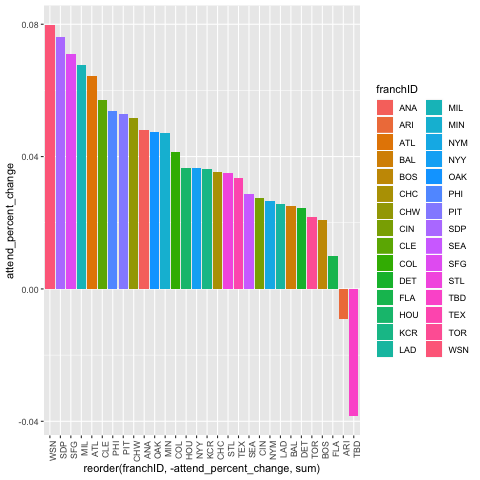

In [105]:
%%R

ggplot(data = mean_win_attend, aes(x=reorder(franchID,-attend_percent_change,sum), y = attend_percent_change, fill = franchID)) + 
    geom_bar(stat = 'identity') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [111]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot(data = playoff_appear, aes(x=reorder(franchID,-playoff_boolean,sum), y = playoff_boolean, fill = franchID)) + 
    geom_bar(stat = 'identity') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggsave('../images/playoff_appearances.pdf')

R[write to console]: Saving 8.5 x 11 in image



stadium stuff
---